### Using [Football Statsbomb Data] from *FA Women's Super League*

#### Tutorial will cover:
- Downloading and Parsing Football Json Data
- Building Basic Logistic Regression Model
- Evaluating Model using ROC Curve
- Feature Engineering
- Building Piecewise Model

#### Dependencies Include:
- pandas
- numpy
- scikit-learn
- matplotlib

[Football Statsbomb Data]: https://github.com/statsbomb/open-data "Statsbomb Open Data Github Repository"

In [1]:
# Nice trick for high-resolution figures on retina screen
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set random seed for reproducability
np.random.seed(42)

### Downloading and Parsing Statsbomb Data

In [4]:
import requests

In [5]:
# Statsbomb's competition 37
import re, json, requests

url = 'https://raw.githubusercontent.com/Kkumar-20/My_Thesis/main/data/matches/37/42.json'

resp = requests.get(url)
resp_parsed = re.sub(r'^jsonp\d+\(|\)\s+$', '', resp.text)
football = json.loads(resp_parsed)

# Use list comprehension to create a list of match ids
mat_id = [f['match_id'] for f in football]
print("There are {} games in this list".format(len(mat_id)))

There are 87 games in this list


#### Football Data Display

In [6]:
import pandas as pd
pd.DataFrame.from_dict(football[0])

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,metadata,match_week,competition_stage,stadium,referee
competition_id,2275127,2019-10-13,15:00:00.000,37,NaN,NaN,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
country_name,2275127,2019-10-13,15:00:00.000,England,NaN,NaN,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
competition_name,2275127,2019-10-13,15:00:00.000,FA Women's Super League,NaN,NaN,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
season_id,2275127,2019-10-13,15:00:00.000,NaN,42,NaN,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
season_name,2275127,2019-10-13,15:00:00.000,NaN,2019/2020,NaN,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
home_team_id,2275127,2019-10-13,15:00:00.000,NaN,NaN,974,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
home_team_name,2275127,2019-10-13,15:00:00.000,NaN,NaN,Reading WFC,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
home_team_gender,2275127,2019-10-13,15:00:00.000,NaN,NaN,female,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
home_team_group,2275127,2019-10-13,15:00:00.000,NaN,NaN,None,NaN,3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,NaN,NaN
country,2275127,2019-10-13,15:00:00.000,NaN,NaN,"{'id': 68, 'name': 'England'}","{'id': 68, 'name': 'England'}",3,2,available,scheduled,2022-12-01T11:34:25.814154,2021-06-13T16:17:31.694,NaN,4,NaN,"{'id': 68, 'name': 'England'}","{'id': 68, 'name': 'England'}"


In [7]:
data = []

# template URL at which each game's event data is stored
match_data_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{}.json"

# This takes some time, naturally
for match_id in mat_id:
    
    # Get all events from a particular game
    all_events = requests.get(url=match_data_url.format(match_id)).json()
        
    # Filter them by type-name Pass
    passes = [x for x in all_events if x['type']['name'] == "Pass"]
    
    for p in passes:
        attributes = {
            "x": p['location'][0],
            "y": p['location'][1],
            "end_x": p['pass']['end_location'][0],
            "end_y": p['pass']['end_location'][1],
            "length": p['pass']['length'],
            "angle": p['pass']['angle'],
            # Multiple other features can be collected here, such as pressure
            "outcome": 0 if "outcome" in p['pass'] else 1
        }
        
        data.append(attributes)

In [8]:
# How many passes are we dealing with?
print("Total Passes is {}".format(len(data)))

Total Passes is 78635


In [9]:
# Build Pandas Dataframe
df = pd.DataFrame(data=data, columns=["outcome", "x", "y", "end_x", "end_y", "length", "angle"])
df.head()

,outcome,x,y,end_x,end_y,length,angle
0,1,61.0,40.1,47.7,49.4,16.228987,2.531372
1,1,50.4,50.5,80.5,25.2,39.320477,-0.698971
2,0,80.3,25.7,71.0,53.4,29.219515,1.894711
3,1,49.1,26.7,36.0,9.9,21.303755,-2.233075
4,0,35.6,9.2,40.3,11.0,5.032892,0.365747


### Plot some Passes!

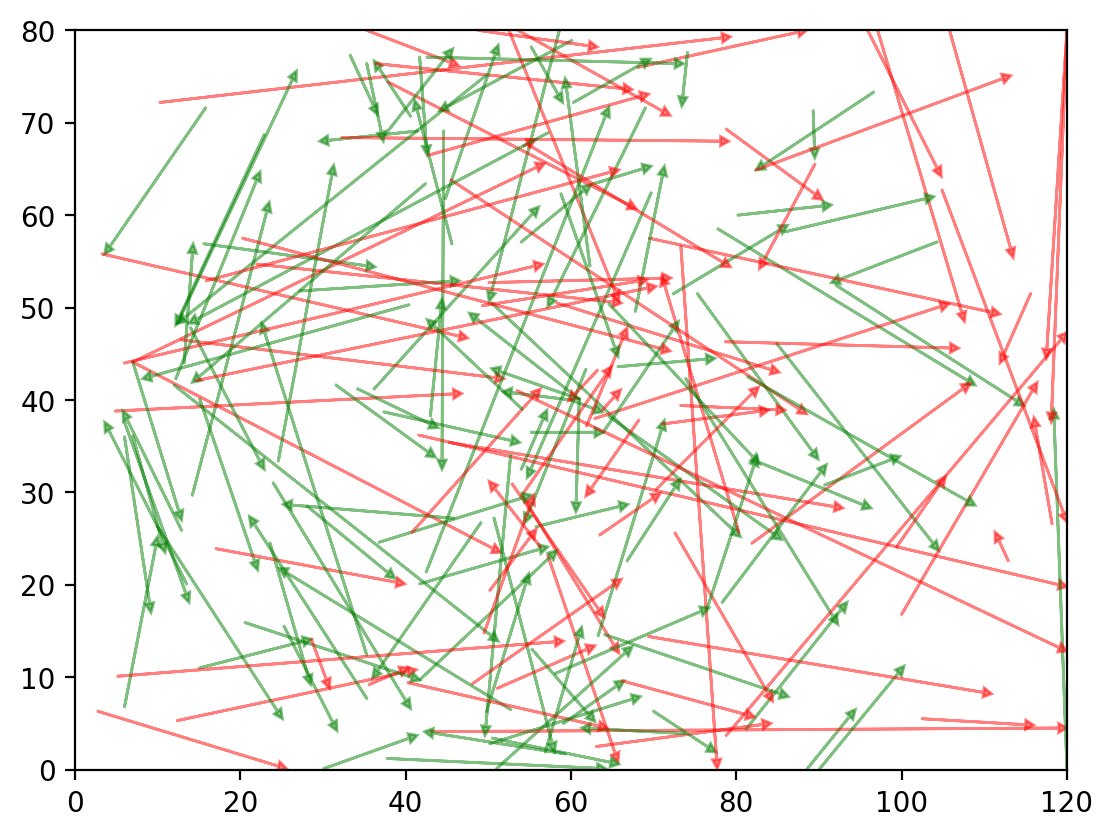

In [10]:
for x,y,end_x,end_y,outcome in df[["x", "y", "end_x", "end_y", "outcome"]].head(200).values:
    
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=1,
              head_length=1,
              color='green' if outcome == 1 else 'red',
              alpha=0.5,
              length_includes_head=True)
    
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

### Baseline Accuracy

In [11]:
# What percentage of overall passes are completed?

baseline_accuracy = df['outcome'].mean()
print("Percentage of baseline_accuracy is {:.1f}%".format(baseline_accuracy*100))

Percentage of baseline_accuracy is 74.3%


### Basic Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
basic_model = LogisticRegression()

features = df[['angle', 'length']]
labels = df['outcome']

basic_model.fit(features, labels)

# Make Predictions
predictions = basic_model.predict_proba(features)[:, 1]

In [14]:
print("First 5 Predictions are {}".format(predictions[:5]))

First 5 Predictions are [0.79918277 0.60923596 0.70800187 0.74392033 0.85010227]


In [15]:
# What percentage of these predictions are "correct"?
correct = 0

for i, prob in enumerate(predictions):
    pred = 1 if prob > 0.5 else 0
    
    if pred == labels[i]:
        correct += 1
        
print("{} of {} correct is {:.2f}".format(correct, len(labels), correct/len(labels)))
print("Percentage of Accurancy of Predictions is {:.2f}%".format(correct/len(labels) * 100))

59886 of 78635 correct is 0.76
Percentage of Accurancy of Predictions is 76.16%


### Sensitivity and Specificity (Slides)

### Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix

threshold = 0.5
confusion_matrix(labels, [1 if prob > threshold else 0 for prob in predictions])

# How to Read Confusion Matrix:

# True Negatives, False Positives
# False Negatives, True Positives

array([[ 2493, 17688],
       [ 1061, 57393]])

### Evaluating Predictions using ROC

ROC = Receiver Operating Characteristic

AUC = Area Under Curve

In [17]:
from sklearn import metrics

In [18]:
def draw_roc(labels, predictions):
    fpr, tpr, thresholds = metrics.roc_curve(labels, predictions, pos_label=1)
    auc = metrics.roc_auc_score(labels, predictions)
    plt.plot(fpr,tpr,label="AUC: {:.3f}".format(auc))
    plt.plot([0,1], [0,1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc=4)
    plt.show()

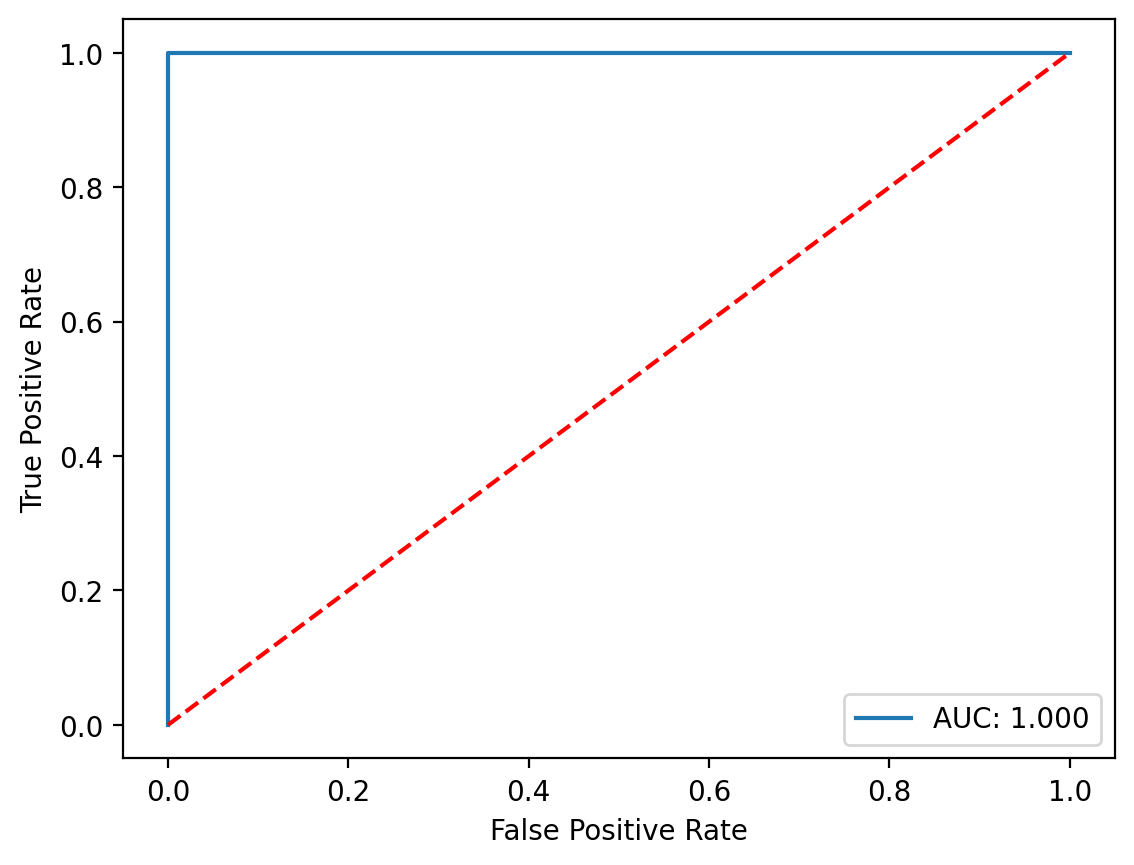

In [19]:
# Perfect ROC
draw_roc(labels, labels)

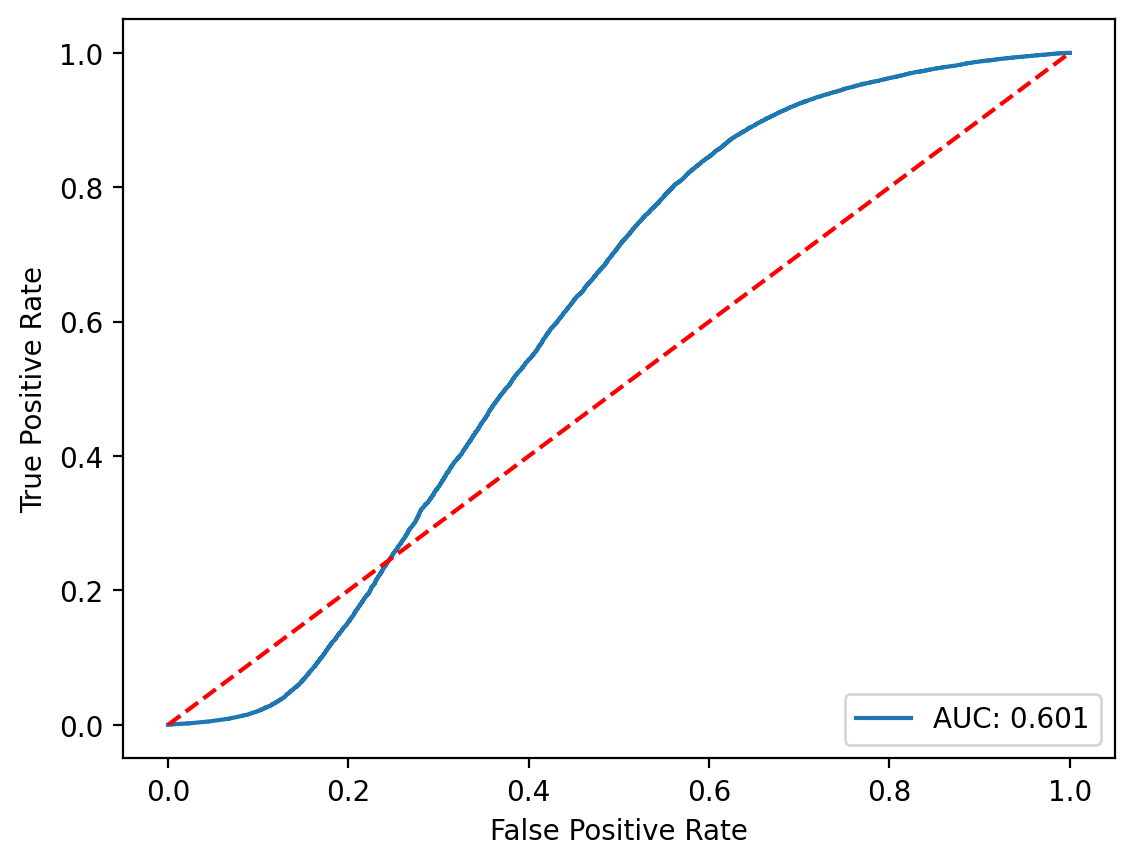

In [20]:
# ROC for regression predictions
draw_roc(labels, predictions)

### Feature Engineering

In [21]:
# Angle is provided in radians and ranges from -pi to +pi
# An angle of 0 is directly up the field

bins = np.linspace(-3.14,3.14,31)
df['angle_bin'] = pd.cut(df['angle'], bins=bins)

In [22]:
# Create new column in data frame
df['abs_angle'] = abs(df['angle'])
df.head()

,outcome,x,y,end_x,end_y,length,angle,angle_bin,abs_angle
0,1,61.0,40.1,47.7,49.4,16.228987,2.531372,"(2.512, 2.721]",2.531372
1,1,50.4,50.5,80.5,25.2,39.320477,-0.698971,"(-0.837, -0.628]",0.698971
2,0,80.3,25.7,71.0,53.4,29.219515,1.894711,"(1.884, 2.093]",1.894711
3,1,49.1,26.7,36.0,9.9,21.303755,-2.233075,"(-2.303, -2.093]",2.233075
4,0,35.6,9.2,40.3,11.0,5.032892,0.365747,"(0.209, 0.419]",0.365747


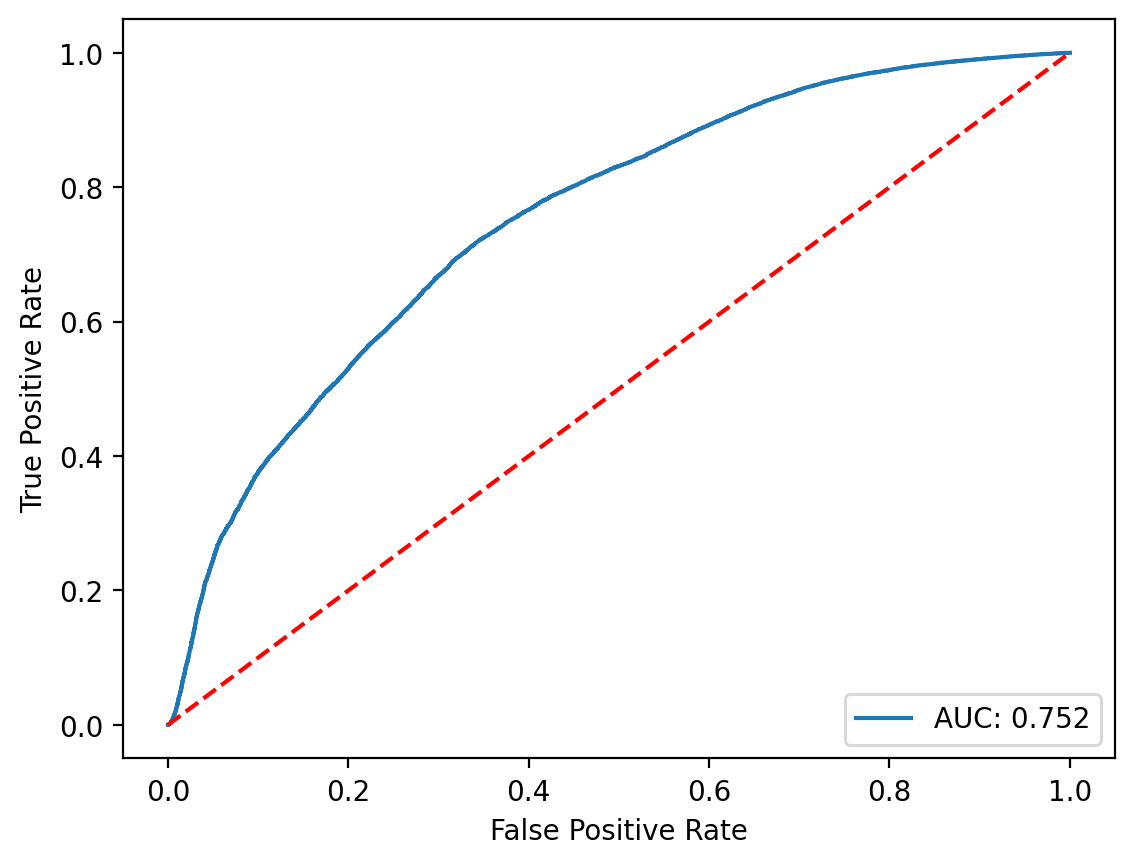

In [23]:
# Build another logistic regression model using new features
adjusted_model = LogisticRegression()

features = df[['abs_angle', 'length']]
labels = df['outcome']
basic_model.fit(features,labels)

predictions = basic_model.predict_proba(features)[:, 1]

draw_roc(labels, predictions)

### Build Piecewise Model

In [24]:
from sklearn.cluster import KMeans

In [25]:
# Cluster all passes into 50 different types
cluster_model = KMeans(n_clusters=50).fit(df[['x','y','end_x','end_y']])

# store cluster classification as an additional column in data frame
df['cluster'] = cluster_model.predict(df[['x','y','end_x','end_y']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


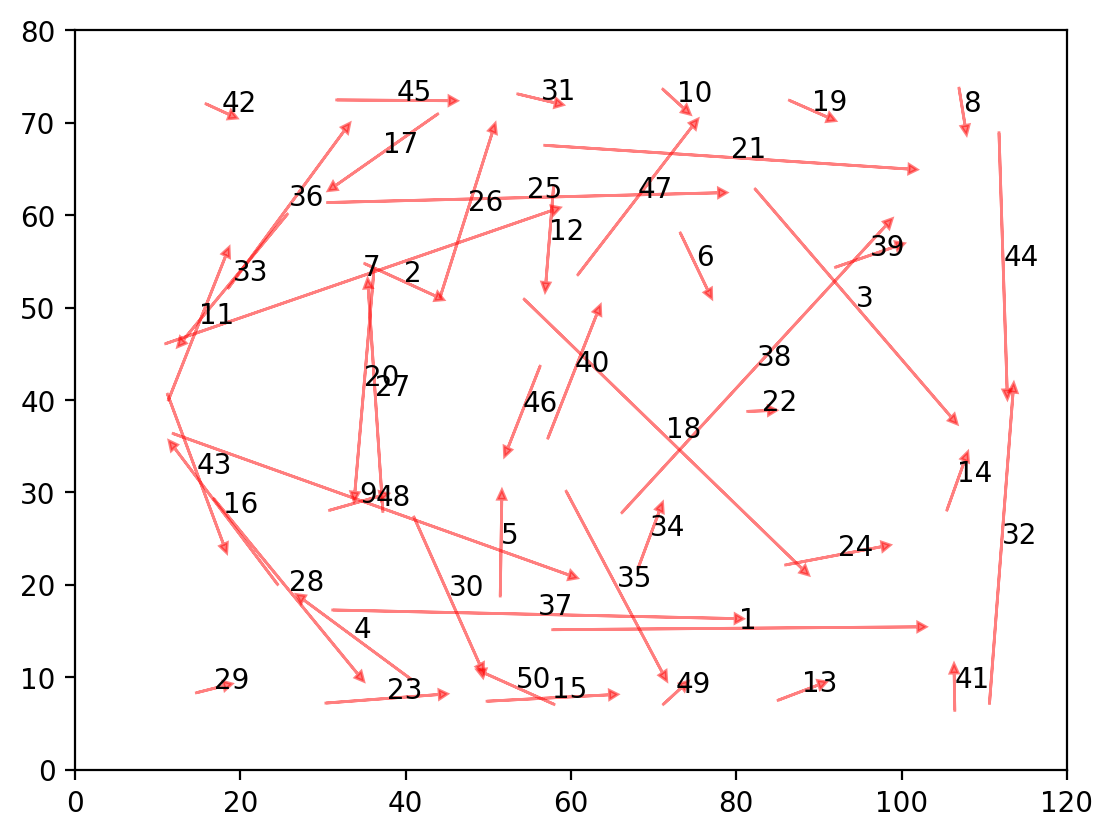

In [26]:
# Plot all clusters
for i, (x, y, end_x, end_y) in enumerate(cluster_model.cluster_centers_):
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=1,
              head_length=1,
              color='red',
              alpha=0.5,
              length_includes_head=True)
    
    plt.text((x+end_x)/2, (y+end_y)/2, str(i+1))
    
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

In [27]:
df.head()

,outcome,x,y,end_x,end_y,length,angle,angle_bin,abs_angle,cluster
0,1,61.0,40.1,47.7,49.4,16.228987,2.531372,"(2.512, 2.721]",2.531372,39
1,1,50.4,50.5,80.5,25.2,39.320477,-0.698971,"(-0.837, -0.628]",0.698971,17
2,0,80.3,25.7,71.0,53.4,29.219515,1.894711,"(1.884, 2.093]",1.894711,21
3,1,49.1,26.7,36.0,9.9,21.303755,-2.233075,"(-2.303, -2.093]",2.233075,29
4,0,35.6,9.2,40.3,11.0,5.032892,0.365747,"(0.209, 0.419]",0.365747,22


In [28]:
# Build an individualized logistic regression model for each pass type
models = {}

for i, e in enumerate(cluster_model.cluster_centers_):
    passes_in_cluster = df[df['cluster'] == i]
    
    models[i] = LogisticRegression()
    
    features = passes_in_cluster[['abs_angle', 'length']]
    labels = passes_in_cluster['outcome']
    
    models[i].fit(features,labels)

In [29]:
def get_prediction(cluster, abs_angle, length):
    v = np.array([abs_angle, length]).reshape(1,-1)    
    return models[cluster].predict_proba(v)[:, 1]

In [30]:
# vectorize get prediction funtion for fast results
get_prediction = np.vectorize(get_prediction)

# create additional column in data frame to store predictions
df['predictions'] = get_prediction(df['cluster'], df['abs_angle'], df['length'])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

In [31]:
df.head()

,outcome,x,y,end_x,end_y,length,angle,angle_bin,abs_angle,cluster,predictions
0,1,61.0,40.1,47.7,49.4,16.228987,2.531372,"(2.512, 2.721]",2.531372,39,0.979547
1,1,50.4,50.5,80.5,25.2,39.320477,-0.698971,"(-0.837, -0.628]",0.698971,17,0.469794
2,0,80.3,25.7,71.0,53.4,29.219515,1.894711,"(1.884, 2.093]",1.894711,21,0.919039
3,1,49.1,26.7,36.0,9.9,21.303755,-2.233075,"(-2.303, -2.093]",2.233075,29,0.983982
4,0,35.6,9.2,40.3,11.0,5.032892,0.365747,"(0.209, 0.419]",0.365747,22,0.718357


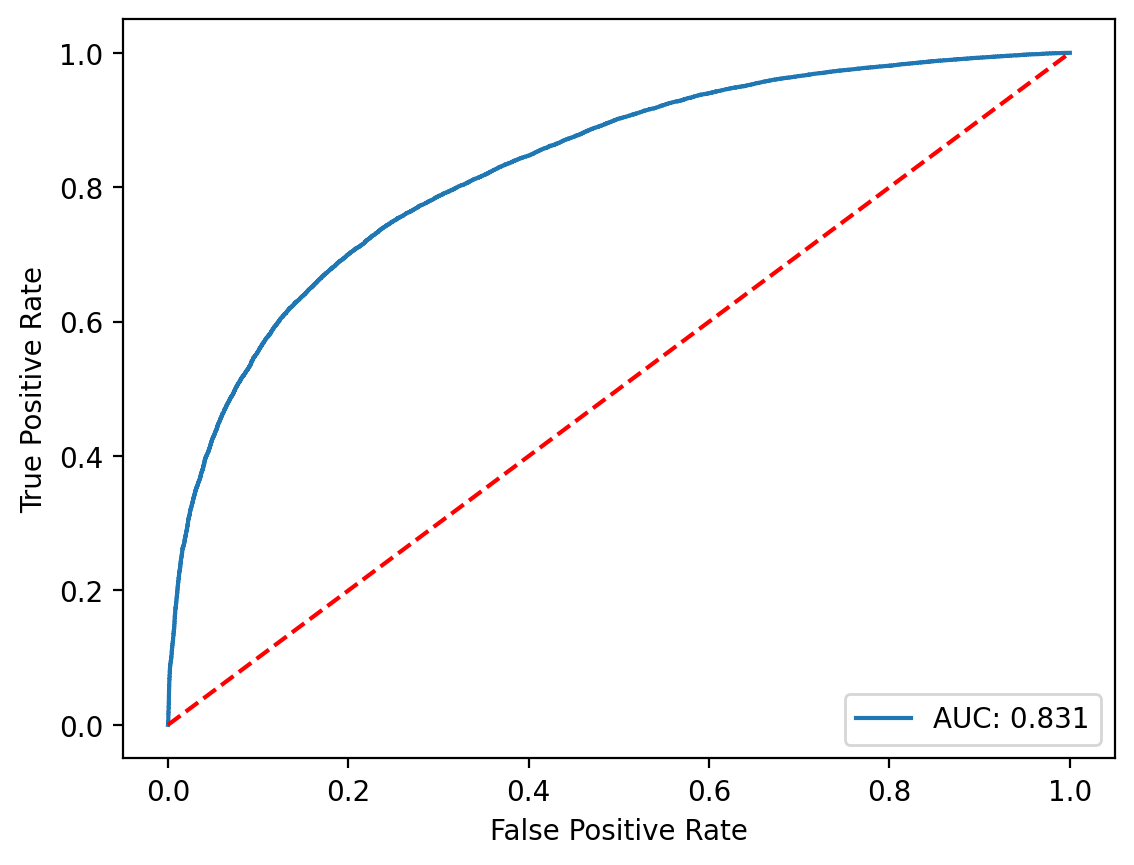

In [32]:
# Draw ROC of final piecewise model
draw_roc(df['outcome'], df['predictions'])